## **[Week 6] Regression**

* Implement linear regression with synthetic data
* Implement two logistic regression models with titanic dataset
  * using linear model
  * using neural network

**[Important]** \\
This lab session will be conducted via **Zoom** on **October 4th** (Wed.) due to the temporary holiday.\
So, you don't have to submit the summary report for this week.\
After TA's presentation, please wait a moment for Q&A. We will make available to BreakRooms, then feel free to ask TAs using Zoom chat or microphone.

### 1. Overview  
Regression is a method to model the relationship between one or more input variables. This week, we focus on supervised learning which has dependent variable($y$) and independent variable($x$).  
Formally, given dependent variables($x$) and independent variables($y$), find a function $f^*=argmin_f \mathbb{E}_{(x,y)\sim D}[l(f(x),y)]$  
 where $l$ is a loss function and $D$ is a distribution over examples $(x,y)$.  
 Practically, since knowing $D$ and searching over all functions is impossible, we use some estimation and approximation as follows:
 * estimation: sample $(x_i,y_i)$ from $D$
 * approximation: search over $F=\{f_\theta|\theta\in\Theta\}$, parameterized functions  

We now find $\hat \theta = argmin_\theta \frac{1}{N}\Sigma_{i=1}^N l(f_\theta(x_i),y_i)$ to obtain $f_\theta\approx f^*$.

 This week, we implement regression models with several different parameterizations $f_\theta$.

Part 2.   $f_\theta(x) = \theta_0^T x + \theta_1$   
Part 3-1. $f_\theta(x) = \frac{1}{1+e^{-\theta^Tx}}$  
Part 3-2. $f_\theta(x) = \frac{1}{1+e^{-NN(x;\theta)}}$ where NN is a neural network

###2. Linear regression  


Import the required packages and fix seed for reproduction

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import torch.optim as optim
import random

# Set random seeds fixed for reproducibility
seed = 7    # Do NOT change the seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

Generate simple synthetic dataset

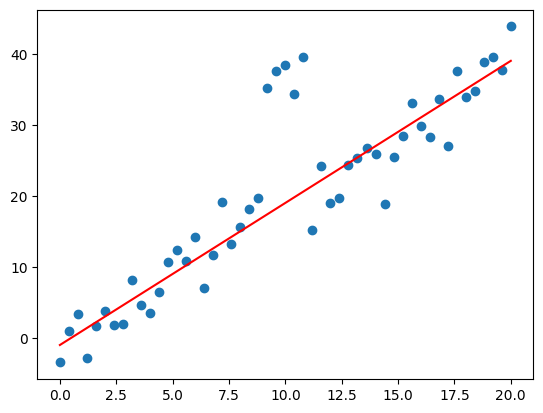

In [ ]:
# true answer: y = 2 * x- 1
X = torch.linspace(0,20,51)
noise = torch.randn(51)
y = 2*X-1+noise*3
y[23:28]= y[23:28]+20 # outlier
plt.plot(X,y,'o')
plt.plot(X,2*X-1,'r')
plt.show()

#### 2-1. Construct Linear model  
This contains parameter $\theta$ which is an optimization variable and forward method which returns $\theta_0x+\theta_1$.

In [ ]:
#linear model
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression,self).__init__()
    #define parameter
    self.theta = nn.Parameter(torch.zeros(2))

  def forward(self,x):
    return self.theta[0] * x + self.theta[1]

model = LinearRegression()
model.theta #requires_grad=True

Parameter containing:
tensor([0., 0.], requires_grad=True)

#### 2-2. Main loop  
* we use SGD optimizer
* we use MSE(Mean Squared Error), i.e. $L(\theta;X,y):=\frac{1}{N}\Sigma_{i=1}^N (f_\theta(x_i)-y_i)^2$  
* Repeat (1) reset gradient (2) backward propagation (3) update parameter

In [ ]:
# loop
n_epochs = 200

#optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

loss_list = list()

for e in range(n_epochs):
  pred = model(X) #y_hat
  loss = torch.sum((pred - y)**2)/len(X)
  loss_list.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

#### 2-3. Check the results  
Observe the obtained $\theta$

In [ ]:
model.theta

Parameter containing:
tensor([2.0128, 0.1800], requires_grad=True)

Plot the training loss

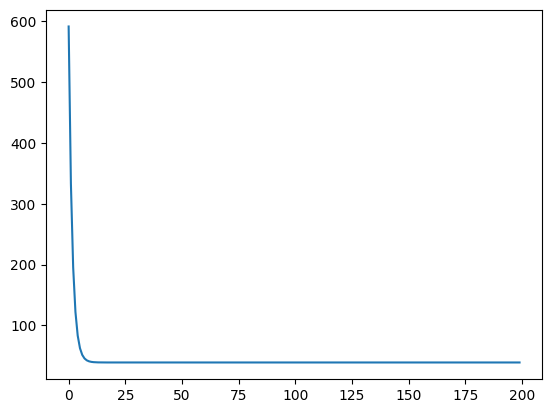

In [ ]:
plt.plot(loss_list)
plt.show()

Visualize the obtained model and compare to the true answer

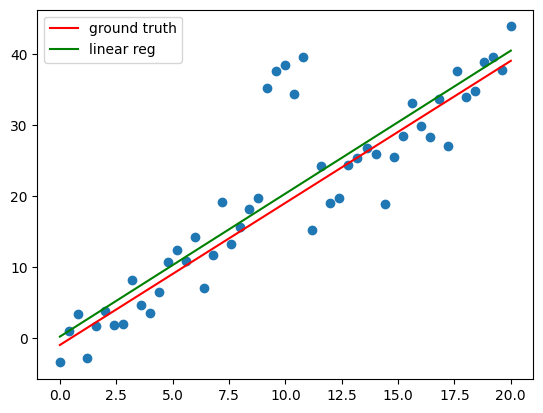

In [ ]:
# true answer: y = 2 * x- 1
plt.plot(X,y,'o')
plt.plot(X,2*X-1,'r',label='ground truth')
pred = [yhat.detach() for yhat in model(X)]
plt.plot(X,pred,'g',label='linear reg')
plt.legend()
plt.show()

###3 . Logistic regression  
In this part, we implement logistic model to deal with titanic dataset.  
You have personal information dataset($X$) of passenger in titanic and binary label($y$) which indicates whether the passenger has survived.  

Binary classification can be solved by regression.  
You will construct model $f_\theta$ so that estimate $p(y=1|x)\approx\frac{1}{1+e^{-f_\theta (x)}}$.  
If $f_\theta(x_i)\ge0$(i.e. estimated $p(y=1|x)\ge0.5$) then make a prediction $\hat y_i=1$, otherwise, $\hat y_i=0$

We find $\theta$ such that $p(y=1|x)\approx\frac{1}{1+e^{-f_\theta (x)}}$ under parameterizations  
3-1. $f_\theta(x)=\theta^Tx$  
3-2. $f_\theta(x)=NN(x;\theta)$ where NN is a Neural Network with weights $\theta$

#### 3-1. Logistic regression with linear model

Import the required packages and fix seed for reproduction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
from matplotlib import pyplot as plt

# URL to the Titanic dataset
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

# Make a GET request to the URL and read the content into a pandas DataFrame
response = requests.get(url).text
data = pd.read_csv(StringIO(response))

Observe the dataset

In [ ]:
# Display the first few rows of the dataset
print(data.head())

   Survived  Pclass                                               Name  \
0         0       3                             Mr. Owen Harris Braund   
1         1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1       3                              Miss. Laina Heikkinen   
3         1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4         0       3                            Mr. William Henry Allen   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0    male  22.0                        1                        0   7.2500  
1  female  38.0                        1                        0  71.2833  
2  female  26.0                        0                        0   7.9250  
3  female  35.0                        1                        0  53.1000  
4    male  35.0                        0                        0   8.0500  


####Data preprocessing  
* There are some missing data. Among several methods to deal with missing data, we just drop them in this practice.  
* Express 'Pclass' and 'Sex' with one-hot encoding and delete the first element for memory efficiency.  
Originally, 'Pclass'$\in${1,2,3} and 'Sex'$\in${'female','male'}. Let us give you some examples for processing.    
  * e.g. 'Pclass'=1$\to$'Pclass'=[1,0,0]$\to$'Pclass'=[0,0](drop the first)
  * e.g. 'Sex'='female'$\to$'Sex'=[1,0]$\to$'Sex'=0(drop the first)

In [ ]:
# Preprocessing
data.dropna(subset=['Age', 'Fare'], inplace=True) # empty -> drop
X = data[['Pclass', 'Sex', 'Age', 'Fare']]
y = data['Survived']
X = pd.get_dummies(X, columns=['Pclass', 'Sex'], drop_first=True) # one-hot encoding
# drop the first to reduce complexity e.g. Pclass=3->001->00, Pclass=1->100->00, male->1, female->0

In [ ]:
print(X.head())

    Age     Fare  Pclass_2  Pclass_3  Sex_male
0  22.0   7.2500         0         1         1
1  38.0  71.2833         0         0         0
2  26.0   7.9250         0         1         0
3  35.0  53.1000         0         0         0
4  35.0   8.0500         0         1         1


Split the dataset into training and test dataset and scale them

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

####Implement logistic regression and check the accuracy

In [ ]:
# Logistic Regression
model = LogisticRegression(penalty=None)
model.fit(X_train_scaled, y_train)

LogisticRegression(penalty=None)

In [ ]:
# train accuracy
y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

Train Accuracy: 0.8124118476727785


In [ ]:
# Predictions
y_pred = model.predict(X_test_scaled)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7528089887640449


In [ ]:
model.coef_

array([[-0.39683152,  0.07335399, -0.37556721, -1.13493448, -1.29807946]])

#### 3-2. Logistic regression with neural network

Import the required packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

convert dataset to tensor

In [ ]:
# use the X_train_scaled X_test_scaled y_train y_pred
# CE with one-hot
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32) #, requires_grad=True)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32) #, requires_grad=True)
y_train_tensor = y_train.astype(float)
y_test_tensor = y_test.astype(float)
y_train_tensor = torch.tensor(y_train_tensor.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_tensor.values, dtype=torch.long)

####Function approximation
* Construct a network $f_\theta$
* Observe the parameters in your model

In [ ]:
class NN(nn.Module):
  def __init__(self):
    super(NN,self).__init__()
    self.fc1 = nn.Linear(5,8)
    self.fc2 = nn.Linear(8,1)
    self.activation = nn.ReLU()

  def forward(self,x):
    #x = F.relu(self.fc1(x))
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    return x

In [ ]:
regmodel=NN() #regression model
regmodel.to(torch.float32)
param=list(regmodel.parameters())
print(param)

[Parameter containing:
tensor([[-0.1953,  0.1502,  0.2574,  0.0063, -0.1740],
        [ 0.2449, -0.2451, -0.1050,  0.4219,  0.0824],
        [ 0.0315,  0.1508, -0.1091,  0.3826, -0.3648],
        [-0.1230, -0.0773, -0.1840, -0.1107,  0.2772],
        [ 0.2454,  0.0249,  0.3896, -0.3158, -0.2667],
        [ 0.2021, -0.0240, -0.4075, -0.3095, -0.2722],
        [ 0.3453,  0.2025,  0.3460, -0.3329, -0.4360],
        [-0.2933,  0.0478, -0.0883, -0.2818,  0.3256]], requires_grad=True), Parameter containing:
tensor([-0.1442, -0.2587,  0.2066, -0.1205,  0.2851,  0.1066,  0.0110,  0.0939],
       requires_grad=True), Parameter containing:
tensor([[-0.2657, -0.1892, -0.1662, -0.2001,  0.0627,  0.0706, -0.1469,  0.2305]],
       requires_grad=True), Parameter containing:
tensor([-0.1967], requires_grad=True)]


####CrossEntropyLoss(K-dimensianal vector, label among 0~K-1)  
$CE(x,y)=-\Sigma_k \mathbb{I}_{y=k} \log\frac{e^{x_k}}{\Sigma_j e^{x_j}}=-\log\frac{e^{x_y}}{\Sigma_j e^{x_j}}$ where $\mathbb{I}$ is an indicator function.   
Let $\sigma(x) = NN(x;\theta)$. Then, $h(\sigma(x))=\frac{1}{1+e^{-\sigma(x)}}$ indicates $P(y=1|x)$.  
You will use cross-entropy loss in the main loop.

####Main loop  
* Define your optimizer
* Use cross-entropy loss for your loss function. You can use nn.CrossEntropyLoss().
* Note that you cannot put $\sigma(x)$ directly into nn.CrossEntropyLoss().  
 To make a proper argument for nn.CrossEntropyLoss(), make a probability distribution with $\sigma(x)$ as suggested above.

**Exercise 1.**   
Design the cross-entropy loss.  
Hint. Considering that $h(\sigma(x))=\frac{1}{1+e^{-\sigma(x)}}$ estimates $P(y=1|x)$, which one is correct,  
 nn.CrossEntropyLoss$((0,\sigma(x)),y)$ or nn.CrossEntropyLoss$((\sigma(x),0),y)$?

In [ ]:
# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer
#optimizer = optim.SGD(regmodel.parameters(), lr=0.01)
optimizer = optim.Adam(regmodel.parameters(), lr=0.01)

num_epochs = 3000

loss_list2=list()

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    ###### Task 1 ######
    out = regmodel(X_train_tensor)                     # Forward pass
    p=torch.cat((torch.zeros_like(out),out),dim=1)     # binary probability distribution
    loss = criterion(p, y_train_tensor)                # Compute the loss
    ####################

    loss_list2.append(loss)
    loss.backward()        # Backpropagate to compute gradients
    optimizer.step()       # Update the model's parameters

####Results

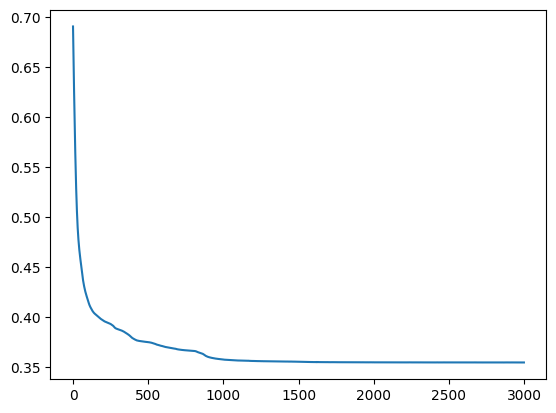

In [ ]:
plt.plot([tensor.detach().numpy() for tensor in loss_list2])
plt.show()

**Exercise 2.**  
Calculate the test accuracy of your "regmodel".  
Your "regmodel" gets passenger information($x$) and returns $\sigma(x)$. From the main loop above, your "regmodel" has trained to satisfy $\frac{1}{1+e^{-\sigma(x)}}\approx P(y=1|x)$.  
making prediction:  
* If $P(y=1|x)\ge0.5$, take prediction($\hat y$) as 1
* If $P(y=1|x)<0.5$, take prediction($\hat y$) as 0  

Your accuracy will be average of the number of data such that prediction matches the true label, i.e., $accuracy=\frac{1}{N}\Sigma_{i=1}^N\mathbb{I}_{\hat y_i=y_i}$.

In [ ]:
###### Task 2 ######
### calculate your test accuracy, named "acc" ###
y_pred2 = [1 if regmodel(X_test_tensor[i])>=0 else 0 for i in range(len(X_test_tensor))]
acc = np.mean([y_pred2[i] == y_test_tensor[i] for i in range(len(y_pred2))])
####################
print("Accuracy: ",acc)

Accuracy:  0.8089887640449438


In [ ]:
# Check whether it shows the same result with metric accuracy_score

# Predictions
y_pred3 = regmodel(X_test_tensor)
y_pred3 = [y3.detach().numpy()>=0 for y3 in y_pred3]

# Convert true labels tensor to numpy array
y_test_np = y_test_tensor.numpy()

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred3)
print("Accuracy:", accuracy)

Accuracy: 0.8089887640449438
